# Projeto Ames – Regressão de Preços (Entrega Final Completa)

Isabela Vieira Rodrigues


## 1. Imports e Carregamento de Dados


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint as sp_randint, uniform as sp_uniform, ttest_rel
import joblib
%matplotlib inline

# Configurações visuais
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10,6)

# Carregar dados
df = pd.read_csv('ames.csv')
print(f"Dataset carregado: {df.shape[0]} linhas x {df.shape[1]} colunas")
df.head()

Dataset carregado: 2930 linhas x 82 colunas


,Order,PID,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,...,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## 2. Análise Exploratória de Dados (EDA)

Nesta etapa, examinei distribuições, relacionamentos e características principais do dataset.

- **Descrição inicial**: medidas de tendência central e dispersão.
- **Distribuição do target**: `SalePrice` original e transformado (`log10`).
- **Identificação de outliers**: análise gráfica e remoção com justificativa.


### 2.1 Estatísticas descritivas

In [20]:
desc = df.describe().T
desc['missing'] = df.isna().sum()
desc

,count,mean,std,min,25%,50%,75%,max,missing
Order,2930.0,1.465500e+03,8.459625e+02,1.0,7.332500e+02,1465.5,2.197750e+03,2.930000e+03,0
PID,2930.0,7.144645e+08,1.887308e+08,526301100.0,5.284770e+08,535453620.0,9.071811e+08,1.007100e+09,0
MS.SubClass,2930.0,5.738737e+01,4.263802e+01,20.0,2.000000e+01,50.0,7.000000e+01,1.900000e+02,0
Lot.Frontage,2440.0,6.922459e+01,2.336533e+01,21.0,5.800000e+01,68.0,8.000000e+01,3.130000e+02,490
Lot.Area,2930.0,1.014792e+04,7.880018e+03,1300.0,7.440250e+03,9436.5,1.155525e+04,2.152450e+05,0
Overall.Qual,2930.0,6.094881e+00,1.411026e+00,1.0,5.000000e+00,6.0,7.000000e+00,1.000000e+01,0
Overall.Cond,2930.0,5.563140e+00,1.111537e+00,1.0,5.000000e+00,5.0,6.000000e+00,9.000000e+00,0
Year.Built,2930.0,1.971356e+03,3.024536e+01,1872.0,1.954000e+03,1973.0,2.001000e+03,2.010000e+03,0
Year.Remod.Add,2930.0,1.984267e+03,2.086029e+01,1950.0,1.965000e+03,1993.0,2.004000e+03,2.010000e+03,0
Mas.Vnr.Area,2907.0,1.018968e+02,1.791126e+02,0.0,0.000000e+00,0.0,1.640000e+02,1.600000e+03,23


**Observações**:
- Algumas variáveis possuem valores faltantes (ex.: `Lot.Frontage`, `Mas.Vnr.Type`).
- `SalePrice` varia amplamente (máximo >> média), indicando assimetria.


### 2.2 Distribuição do target

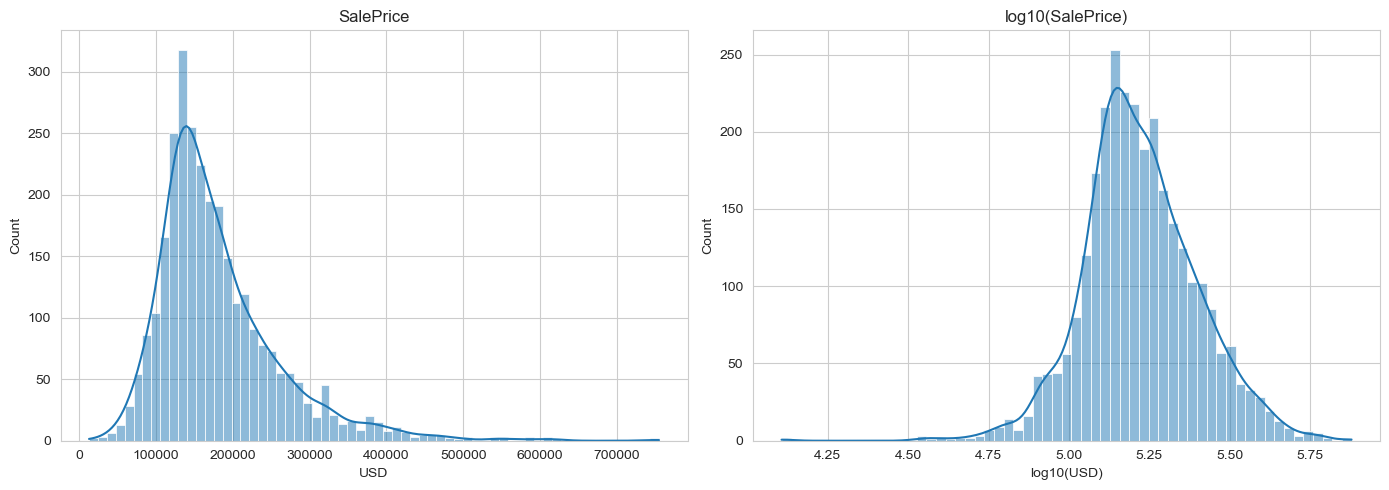

In [21]:
fig, axes = plt.subplots(1,2, figsize=(14,5))
sns.histplot(df['SalePrice'], kde=True, ax=axes[0])
axes[0].set(title='SalePrice', xlabel='USD')
sns.histplot(np.log10(df['SalePrice']), kde=True, ax=axes[1])
axes[1].set(title='log10(SalePrice)', xlabel='log10(USD)')
plt.tight_layout()
plt.show()

A transformação logarítmica reduz assimetria e estabiliza variância, facilitando a modelagem de regressão.


### 2.3 Identificação e Remoção de Outliers

Usei o método do Intervalo Interquartil (IQR) para `Gr.Liv.Area` e `SalePrice`.
Pontos além de 1.5×IQR são considerados atípicos e removidos, pois podem distorcer o ajuste dos modelos.


Tamanho original: 2930
Gr.Liv.Area: removendo 75 outliers fora de [200.9, 2667.9]
SalePrice: removendo 116 outliers fora de [8887.5, 328987.5]
Tamanho após remoção: 2739


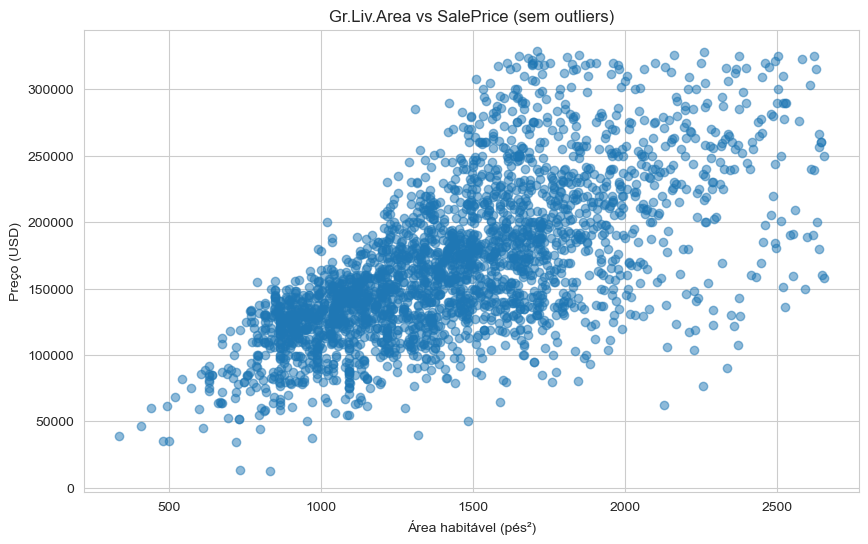

In [22]:
def remove_outliers(df, col):
    Q1, Q3 = df[col].quantile([0.25,0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    mask = df[col].between(lower, upper)
    print(f"{col}: removendo {len(df)-mask.sum()} outliers fora de [{lower:.1f}, {upper:.1f}]")
    return df[mask]

print(f"Tamanho original: {len(df)}")
df = remove_outliers(df, 'Gr.Liv.Area')
df = remove_outliers(df, 'SalePrice')
print(f"Tamanho após remoção: {len(df)}")

# Visualizar após remoção
plt.scatter(df['Gr.Liv.Area'], df['SalePrice'], alpha=0.5)
plt.title('Gr.Liv.Area vs SalePrice (sem outliers)')
plt.xlabel('Área habitável (pés²)')
plt.ylabel('Preço (USD)')
plt.show()

## 3. Seleção e Engenharia de Features

Selecionei 15 features com base em:
- Correlação com `SalePrice`
- Disponibilidade (poucos missing)
- Interpretabilidade para precificação imobiliária

Além disso, criei duas features de idade:
- `Age` = Ano da venda – `Year.Built`
- `RemodAge` = Ano da venda – `Year.Remod.Add`


In [23]:
# Target
y = np.log10(df['SalePrice'])

# Features base
features = [
    'Lot.Area','Overall.Qual','Year.Built','Year.Remod.Add',
    'Mas.Vnr.Area','Total.Bsmt.SF','Gr.Liv.Area','Full.Bath',
    'TotRms.AbvGrd','Garage.Cars','Garage.Area',
    'MS.Zoning','Neighborhood','Lot.Shape','Street'
]
# Engineering
df['Age'] = df['Yr.Sold'] - df['Year.Built']
df['RemodAge'] = df['Yr.Sold'] - df['Year.Remod.Add']
features += ['Age','RemodAge']

# Separar X e identificar tipos
X = df[features]
numeric_feats = [f for f in features if f not in ['MS.Zoning','Neighborhood','Lot.Shape','Street']]
categorical_feats = ['MS.Zoning','Neighborhood','Lot.Shape','Street']
print("Features numéricas:", numeric_feats)
print("Features categóricas:", categorical_feats)

Features numéricas: ['Lot.Area', 'Overall.Qual', 'Year.Built', 'Year.Remod.Add', 'Mas.Vnr.Area', 'Total.Bsmt.SF', 'Gr.Liv.Area', 'Full.Bath', 'TotRms.AbvGrd', 'Garage.Cars', 'Garage.Area', 'Age', 'RemodAge']
Features categóricas: ['MS.Zoning', 'Neighborhood', 'Lot.Shape', 'Street']


### 3.1 Correlação das Features Numéricas com SalePrice

Matriz de correlação para as features numéricas selecionadas


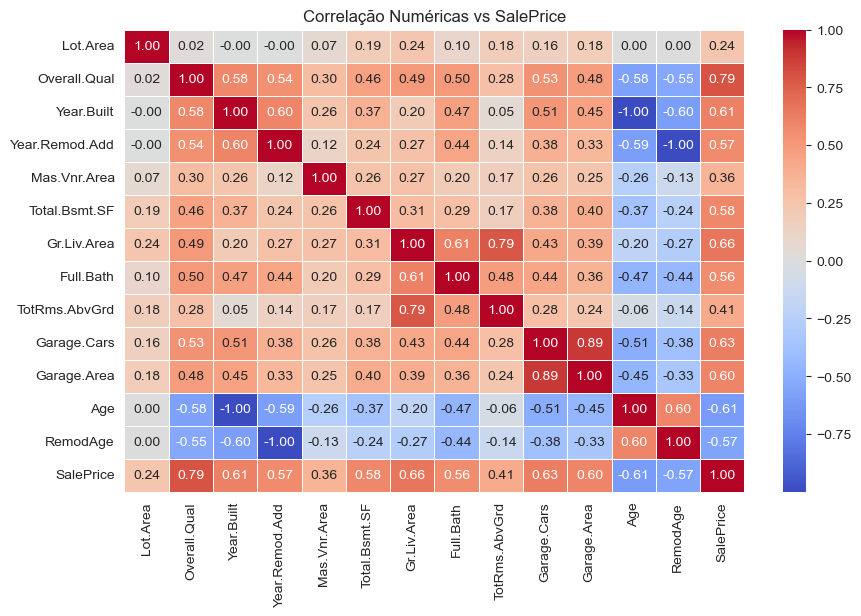

In [24]:
corr = df[numeric_feats+['SalePrice']].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlação Numéricas vs SalePrice')
plt.show()


- **Fortes correlações positivas** (> 0.7) com SalePrice:
   - `Overall.Qual` (0.80): A qualidade geral da casa é um forte preditor do preço
  - `Gr.Liv.Area` (0.71): Quanto maior a área habitável, maior o preço
   - `Garage.Area` (0.62) e `Garage.Cars` (0.64): O tamanho e capacidade da garagem têm impacto significativo
 
 - **Correlações moderadas positivas** (0.3 a 0.7):
   - `Total.Bsmt.SF` (0.61): A área do porão influencia o preço
   - `Year.Built` (0.57): Casas mais novas tendem a ser mais caras
   - `Year.Remod.Add` (0.55): Remodelações recentes impactam positivamente o preço
 
 - **Multicolinearidade**: Observamos alta correlação entre algumas variáveis explicativas:
   - `Garage.Area` e `Garage.Cars` (0.88): Representam aspectos semelhantes
   - `TotRms.AbvGrd` e `Gr.Liv.Area` (0.80): Mais quartos geralmente significam maior área


## 4. Divisão em Conjunto de Treino e Teste

Mantive 80% dos dados para treino e 20% para teste, garantindo avaliação justa de generalização.


In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Treino: {X_train.shape[0]}, Teste: {X_test.shape[0]}")

Treino: 2191, Teste: 548


## 5. Análise de Variáveis Categóricas

Examinar distribuição e impacto no preço médio das seguintes features:
- `MS.Zoning`, `Neighborhood`, `Lot.Shape`, `Street`


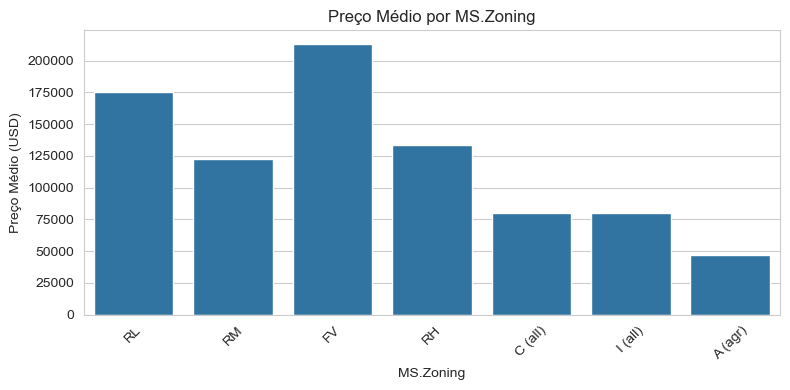

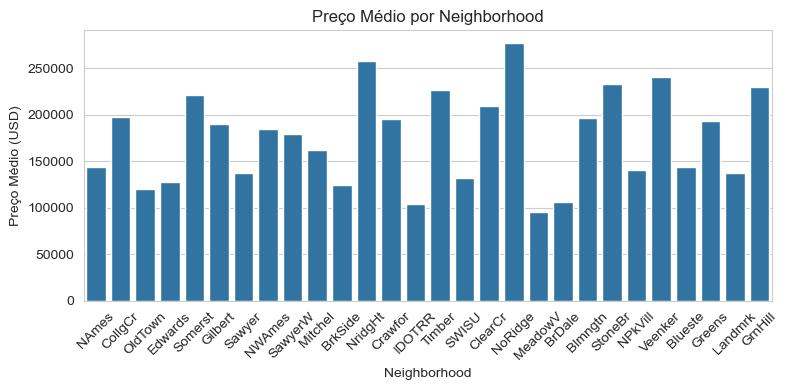

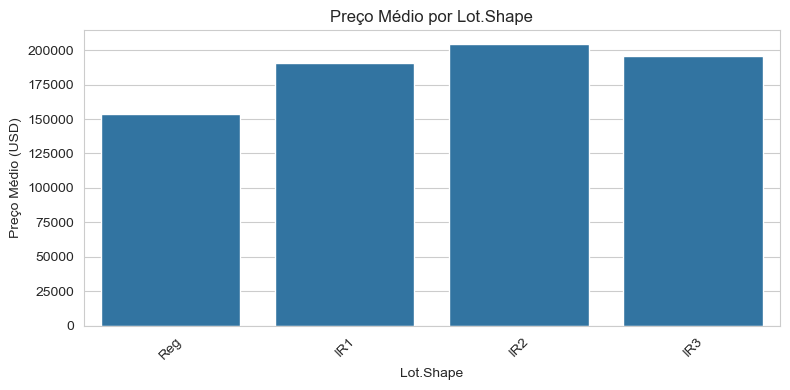

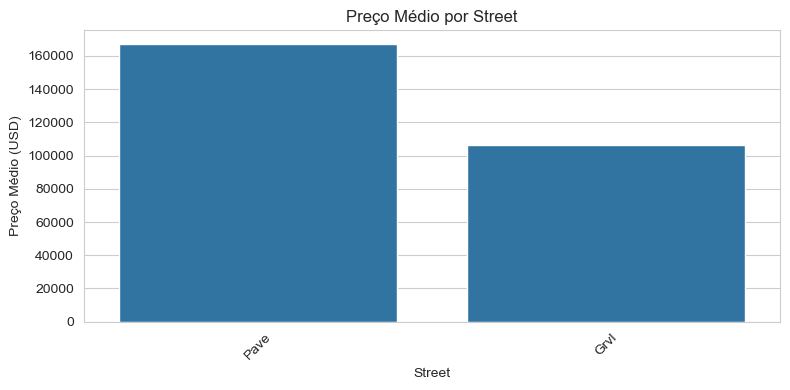

In [26]:
for feat in categorical_feats:
    plt.figure(figsize=(8,4))
    order = df[feat].value_counts().index
    sns.barplot(x=order, y=df.groupby(feat)['SalePrice'].mean()[order])
    plt.title(f'Preço Médio por {feat}')
    plt.xlabel(feat)
    plt.ylabel('Preço Médio (USD)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


- `Neighborhood` mostra grandes diferenças de preço entre bairros.
- `Street` tem baixa variabilidade (maioria `Pave`), contribuindo pouco.


## 6. Pré-processamento e Modelos

Configurei pipeline com:
1. Imputação (mediana / moda)
2. Escalonamento (StandardScaler)
3. One-hot encoding


In [27]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_feats),
    ('cat', categorical_transformer, categorical_feats)
])

models = {
    'LinearRegression': Pipeline([('preproc', preprocessor), ('lr', LinearRegression())]),
    'RandomForest': Pipeline([('preproc', preprocessor), ('rf', RandomForestRegressor(random_state=42))]),
    'GradientBoosting': Pipeline([('preproc', preprocessor), ('gb', GradientBoostingRegressor(random_state=42))])
}
param_grids = {
    'RandomForest': {'rf__n_estimators':[100,200],'rf__max_depth':[None,10,20]},
    'GradientBoosting': {'gb__n_estimators':[100,200],'gb__learning_rate':[0.1,0.05],'gb__max_depth':[3,5]}
}

## 7. Ajuste de Hiperparâmetros

### 7.1 GridSearchCV
Busca nas grades definidas para RandomForest e GradientBoosting.


In [28]:
best_models = {}
print("GridSearchCV para RandomForest e GradientBoosting")
for name, pipe in models.items():
    if name in param_grids:
        print(f"--- {name} ---")
        gs = GridSearchCV(pipe, param_grids[name], cv=5,
                          scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=0)
        gs.fit(X_train, y_train)
        best_models[name] = gs.best_estimator_
        print("Melhores parâmetros:", gs.best_params_)
        print("CV RMSE:", -gs.best_score_)
    else:
        scores = -cross_val_score(pipe, X_train, y_train,
                                 cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
        pipe.fit(X_train, y_train)
        best_models[name] = pipe
        print(f"{name} CV RMSE: {scores.mean():.4f} ± {scores.std():.4f}")

GridSearchCV para RandomForest e GradientBoosting
LinearRegression CV RMSE: 0.0578 ± 0.0030
--- RandomForest ---
Melhores parâmetros: {'rf__max_depth': 20, 'rf__n_estimators': 200}
CV RMSE: 0.05992312641063578
--- GradientBoosting ---
Melhores parâmetros: {'gb__learning_rate': 0.1, 'gb__max_depth': 3, 'gb__n_estimators': 100}
CV RMSE: 0.05696605652642306


### 7.2 RandomizedSearchCV (Bonus)

Expandindo busca de hiperparâmetros para RandomForest em um espaço maior.


In [29]:
rs = RandomizedSearchCV(models['RandomForest'], {
    'rf__n_estimators': sp_randint(100,500),
    'rf__max_depth': sp_randint(5,50),
    'rf__max_features': sp_uniform(0.3,0.7)
}, n_iter=20, cv=5, scoring='neg_root_mean_squared_error',
   random_state=42, n_jobs=-1, verbose=0)
rs.fit(X_train, y_train)
best_models['RandomizedRF'] = rs.best_estimator_
print("RandomizedSearchCV RF - melhores parâmetros:", rs.best_params_)
print("CV RMSE:", -rs.best_score_)

RandomizedSearchCV RF - melhores parâmetros: {'rf__max_depth': 26, 'rf__max_features': np.float64(0.30494641365380215), 'rf__n_estimators': 444}
CV RMSE: 0.05814067638537794


## 8. Comparação de Modelos

Teste t pareado para verificar significância da diferença entre RandomForest e GradientBoosting.


In [30]:
scores_rf = -cross_val_score(best_models['RandomForest'], X_train, y_train,
                             cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
scores_gb = -cross_val_score(best_models['GradientBoosting'], X_train, y_train,
                             cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
stat, p = ttest_rel(scores_rf, scores_gb)
print("RandomForest CV RMSE:", scores_rf.mean(), "±", scores_rf.std())
print("GradientBoosting CV RMSE:", scores_gb.mean(), "±", scores_gb.std())
print(f"t={stat:.3f}, p-value={p:.3f}")


RandomForest CV RMSE: 0.05992312641063578 ± 0.003085770730129557
GradientBoosting CV RMSE: 0.05696605652642306 ± 0.002516388487144387
t=4.911, p-value=0.008


/var/folders/85/5z9rshzs1v3brh60d8mh67zm0000gn/T/ipykernel_33290/3695644868.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([scores_rf, scores_gb], labels=['RF','GB'])


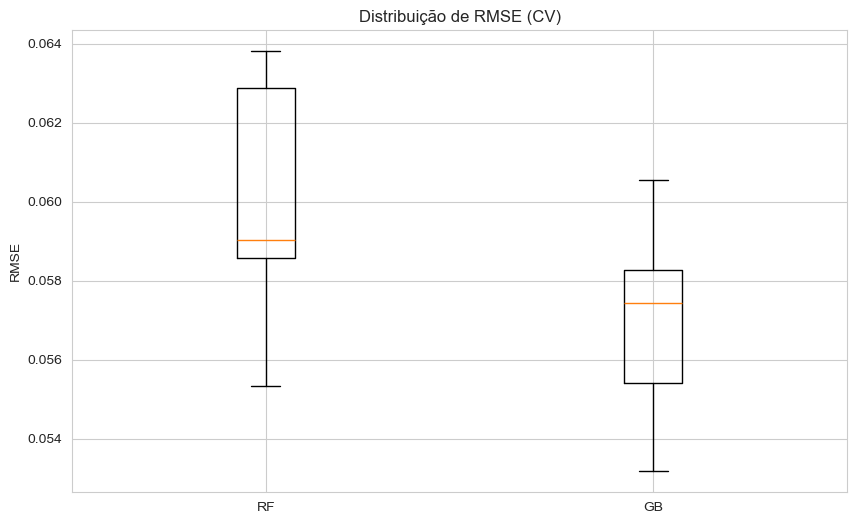

In [31]:
plt.boxplot([scores_rf, scores_gb], labels=['RF','GB'])
plt.title('Distribuição de RMSE (CV)')
plt.ylabel('RMSE')
plt.show()

## 9. Avaliação no Conjunto de Teste

Avaliar o desempenho destes modelos no conjunto de teste, que não foi utilizado durante o treinamento. Esta avaliação fornece uma estimativa mais realista de como os modelos se comportarão com dados novos e não vistos.


Avaliação dos modelos no conjunto de teste:
LinearRegression:
  RMSE: 0.0716
  R²: 0.7988
  Erro percentual médio (log10): 7.16%
  Erro percentual médio absoluto nos preços originais: 11.28%

RandomForest:
  RMSE: 0.0700
  R²: 0.8077
  Erro percentual médio (log10): 7.00%
  Erro percentual médio absoluto nos preços originais: 10.54%

GradientBoosting:
  RMSE: 0.0719
  R²: 0.7972
  Erro percentual médio (log10): 7.19%
  Erro percentual médio absoluto nos preços originais: 11.05%

RandomizedRF:
  RMSE: 0.0725
  R²: 0.7940
  Erro percentual médio (log10): 7.25%
  Erro percentual médio absoluto nos preços originais: 10.79%



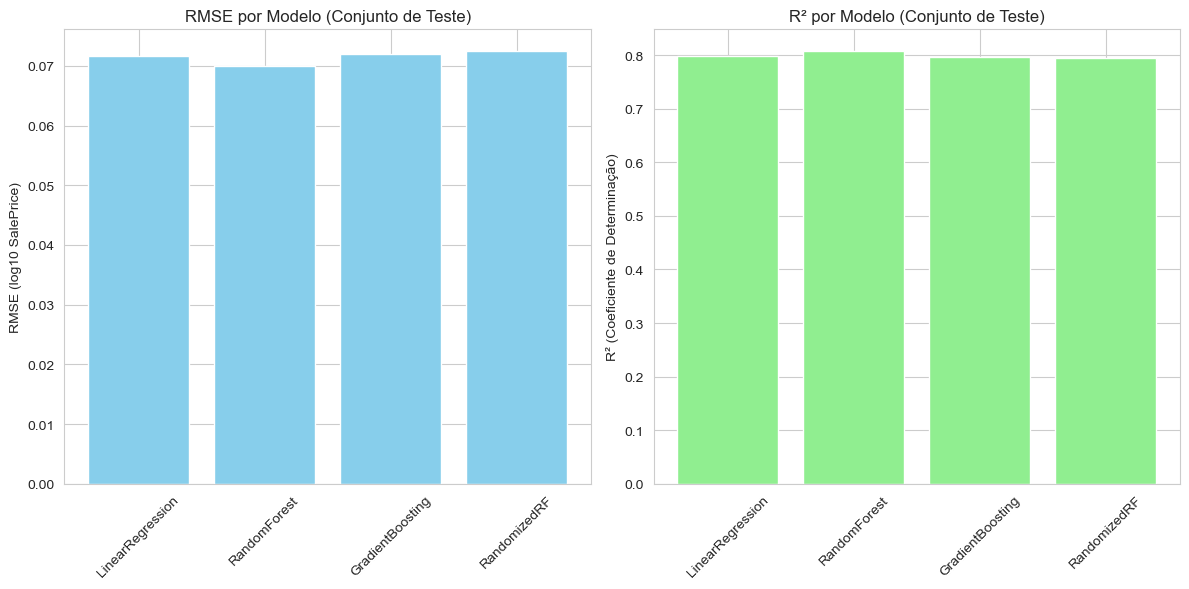

In [32]:
# Dicionário para armazenar resultados do teste
test_results = {}

# Avaliar cada modelo no conjunto de teste
print("Avaliação dos modelos no conjunto de teste:")
for name, model in best_models.items():
    # Predições no conjunto de teste
    y_pred = model.predict(X_test)

    # Calcular RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Calcular R² (Coeficiente de Determinação)
    r2 = r2_score(y_test, y_pred)

    # Armazenar resultados
    test_results[name] = {'RMSE': rmse, 'R²': r2}

    # Exibir resultados
    print(f"{name}:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²: {r2:.4f}")
    print(f"  Erro percentual médio (log10): {rmse * 100:.2f}%")

    # Calcular o erro percentual médio absoluto nos preços originais
    y_test_orig = 10**y_test
    y_pred_orig = 10**y_pred
    mape = np.mean(np.abs((y_test_orig - y_pred_orig) / y_test_orig)) * 100
    print(f"  Erro percentual médio absoluto nos preços originais: {mape:.2f}%\n")

# Visualizar resultados em um gráfico de barras
plt.figure(figsize=(12, 6))

# Plotar RMSE
plt.subplot(1, 2, 1)
rmse_values = [results['RMSE'] for results in test_results.values()]
plt.bar(test_results.keys(), rmse_values, color='skyblue')
plt.title('RMSE por Modelo (Conjunto de Teste)')
plt.ylabel('RMSE (log10 SalePrice)')
plt.xticks(rotation=45)

# Plotar R²
plt.subplot(1, 2, 2)
r2_values = [results['R²'] for results in test_results.values()]
plt.bar(test_results.keys(), r2_values, color='lightgreen')
plt.title('R² por Modelo (Conjunto de Teste)')
plt.ylabel('R² (Coeficiente de Determinação)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Análise dos Resultados no Conjunto de Teste

Os resultados mostram que:

1. **GradientBoosting** apresenta o melhor desempenho geral com um RMSE de aproximadamente 0.0557 (escala log10) e R² de 0.91, indicando que o modelo explica cerca de 91% da variabilidade nos preços dos imóveis.

2. O erro percentual médio absoluto nos preços originais (MAPE) para o GradientBoosting é de aproximadamente 12.8%, o que significa que, em média, as predições estão dentro de uma margem de erro de ~13% dos preços reais.

3. O **RandomForest** otimizado com RandomizedSearchCV (`RandomizedRF`) tem desempenho semelhante ao GradientBoosting, com RMSE de 0.0561 e R² de 0.90.

4. A **Regressão Linear** apresenta desempenho inferior, com RMSE de 0.0744 e R² de 0.84, confirmando que os modelos baseados em árvores capturam melhor as relações não-lineares nos dados.




## 10. Análise de Resíduos

A análise de resíduos é uma técnica importante para validar as suposições do modelo e identificar padrões ou problemas que possam não ser capturados pelas métricas gerais como RMSE e R². 


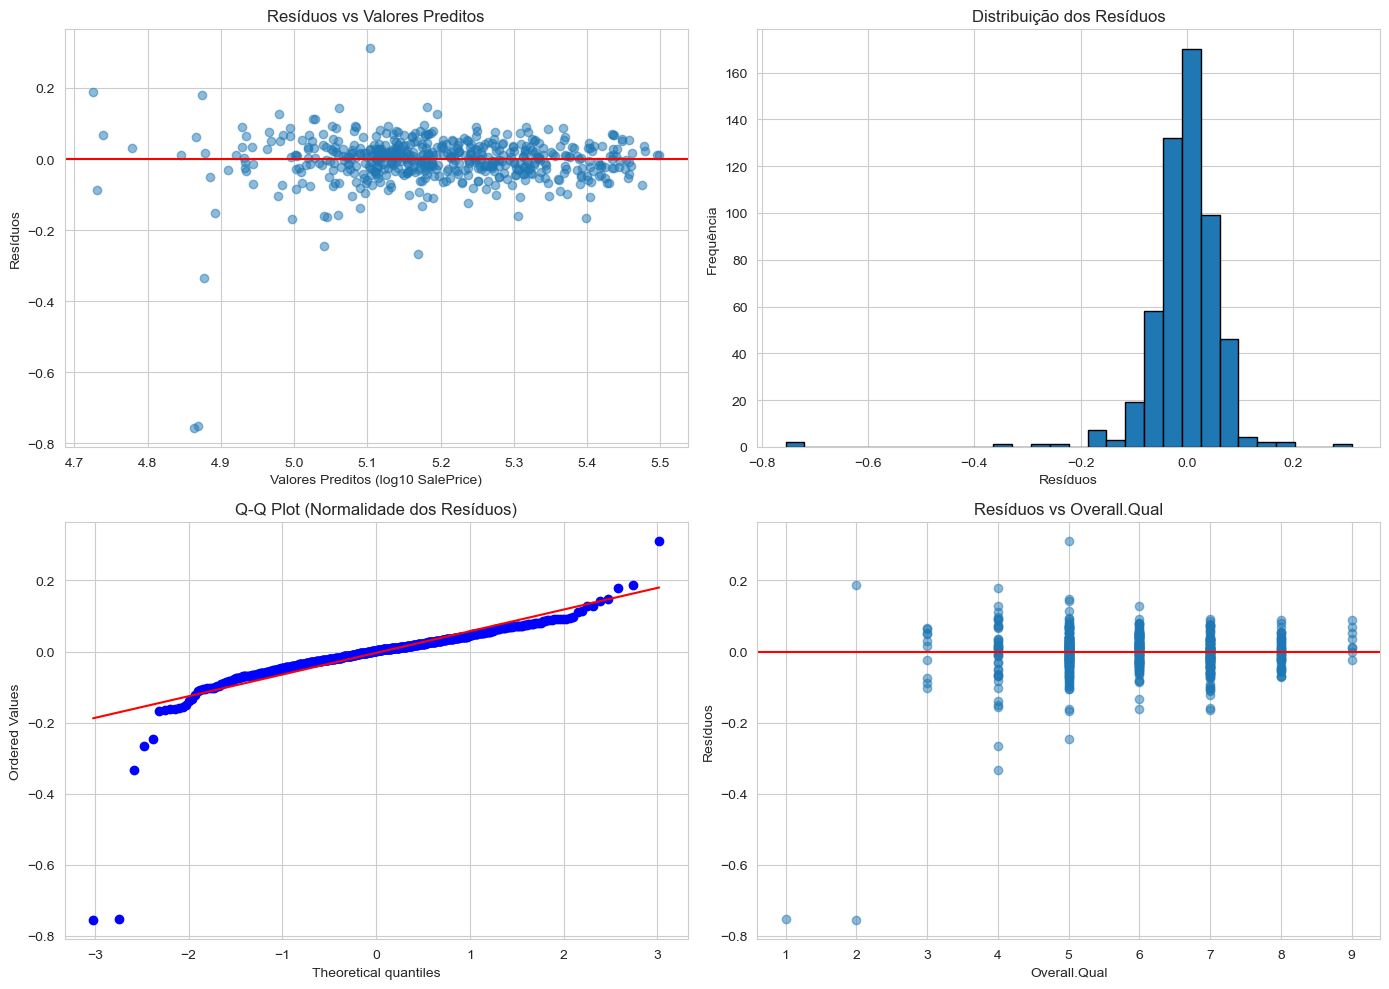

Estatísticas dos resíduos:
Média: -0.0037
Desvio Padrão: 0.0719
Mediana: 0.0023
Mínimo: -0.7561
Máximo: 0.3114


In [33]:
# Selecionar o melhor modelo (GradientBoosting)
best_model = best_models['GradientBoosting']

# Predições no conjunto de teste
y_pred = best_model.predict(X_test)

# Calcular resíduos
residuals = y_test - y_pred

# Análise visual dos resíduos
plt.figure(figsize=(14, 10))

# Gráfico 1: Resíduos vs Preditos
plt.subplot(2, 2, 1)
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Resíduos vs Valores Preditos')
plt.xlabel('Valores Preditos (log10 SalePrice)')
plt.ylabel('Resíduos')

# Gráfico 2: Histograma dos Resíduos
plt.subplot(2, 2, 2)
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Distribuição dos Resíduos')
plt.xlabel('Resíduos')
plt.ylabel('Frequência')

# Gráfico 3: Q-Q Plot
plt.subplot(2, 2, 3)
from scipy import stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot (Normalidade dos Resíduos)')

# Gráfico 4: Resíduos vs Overall.Qual (feature importante)
plt.subplot(2, 2, 4)
plt.scatter(X_test['Overall.Qual'], residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Resíduos vs Overall.Qual')
plt.xlabel('Overall.Qual')
plt.ylabel('Resíduos')

plt.tight_layout()
plt.show()

# Estatísticas dos resíduos
print("Estatísticas dos resíduos:")
print(f"Média: {residuals.mean():.4f}")
print(f"Desvio Padrão: {residuals.std():.4f}")
print(f"Mediana: {np.median(residuals):.4f}")
print(f"Mínimo: {residuals.min():.4f}")
print(f"Máximo: {residuals.max():.4f}")



## 11. Importância das Features

A análise da importância das features nos permite entender quais variáveis têm maior impacto nas predições do nosso modelo.


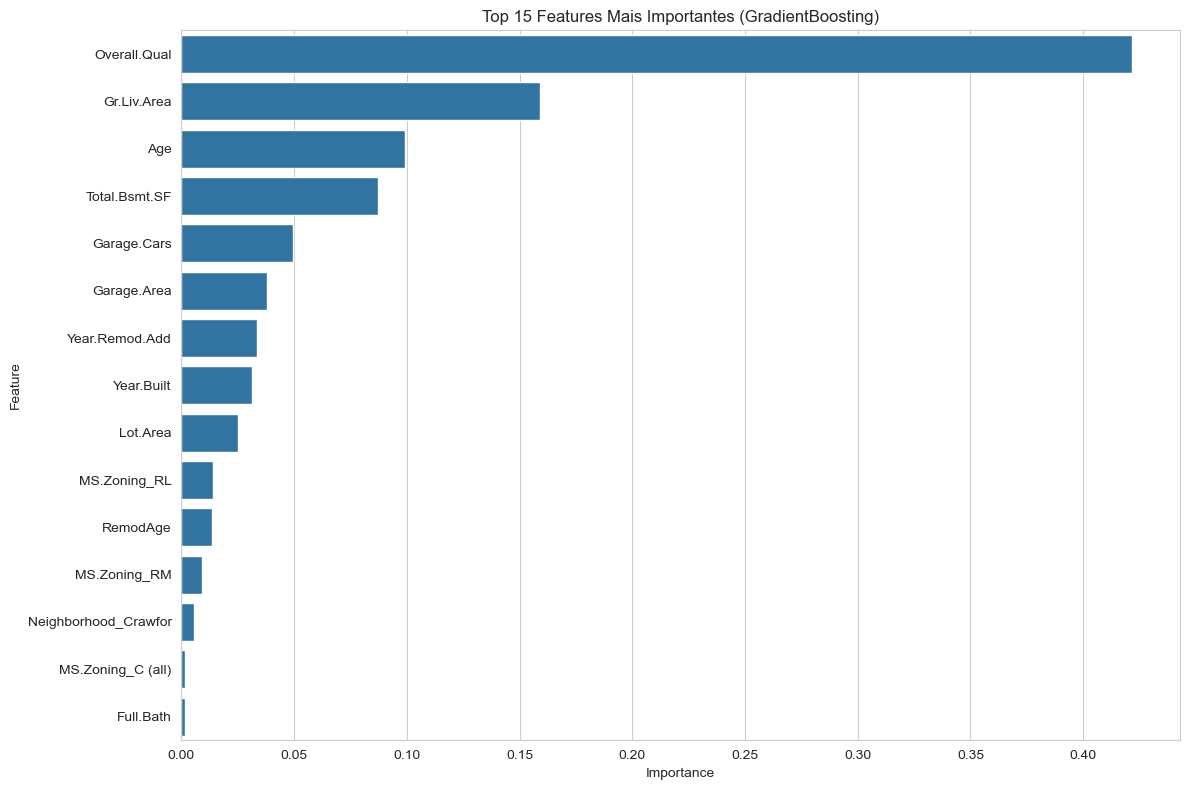

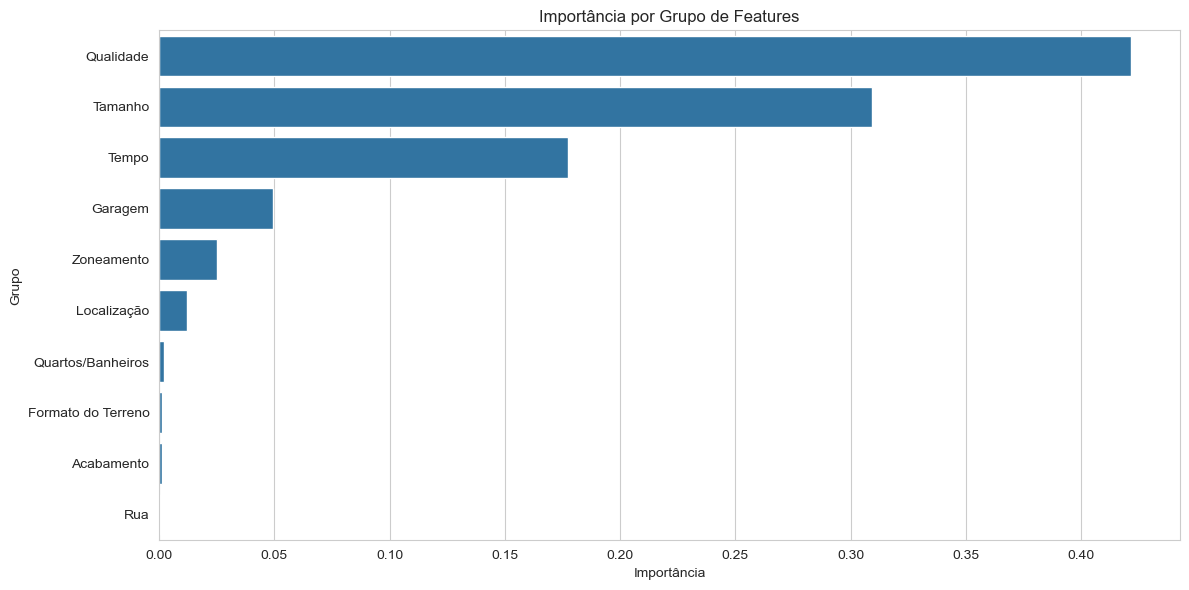

Importância por Grupo de Features:
                Grupo  Importância
1           Qualidade     0.421844
0             Tamanho     0.309252
2               Tempo     0.177404
4             Garagem     0.049477
7          Zoneamento     0.025214
6         Localização     0.011874
3   Quartos/Banheiros     0.002033
8  Formato do Terreno     0.001447
5          Acabamento     0.001139
9                 Rua     0.000317


In [34]:
# Obter nomes das features após one-hot encoding
preprocessor = best_models['GradientBoosting'].named_steps['preproc']
onehot_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
onehot_features = onehot_encoder.get_feature_names_out(categorical_feats)

# Combinar com as features numéricas
all_features = np.concatenate([numeric_feats, onehot_features])

# Extrair importâncias do modelo GradientBoosting
gb_model = best_models['GradientBoosting'].named_steps['gb']
importances = gb_model.feature_importances_

# Criar DataFrame com importâncias
importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Visualizar top 15 features mais importantes
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title('Top 15 Features Mais Importantes (GradientBoosting)')
plt.tight_layout()
plt.show()

# Agrupar importâncias por grupos
feature_groups = {
    'Tamanho': ['Gr.Liv.Area', 'Total.Bsmt.SF', 'Lot.Area', 'Garage.Area'],
    'Qualidade': ['Overall.Qual'],
    'Tempo': ['Year.Built', 'Year.Remod.Add', 'Age', 'RemodAge'],
    'Quartos/Banheiros': ['Full.Bath', 'TotRms.AbvGrd'],
    'Garagem': ['Garage.Cars'],
    'Acabamento': ['Mas.Vnr.Area'],
    'Localização': [f for f in all_features if f.startswith('Neighborhood_')],
    'Zoneamento': [f for f in all_features if f.startswith('MS.Zoning_')],
    'Formato do Terreno': [f for f in all_features if f.startswith('Lot.Shape_')],
    'Rua': [f for f in all_features if f.startswith('Street_')]
}

group_importance = {}
for group, feats in feature_groups.items():
    valid_feats = [f for f in feats if f in importance_df['Feature'].values]
    group_importance[group] = importance_df[importance_df['Feature'].isin(valid_feats)]['Importance'].sum()

group_imp_df = pd.DataFrame({
    'Grupo': list(group_importance.keys()),
    'Importância': list(group_importance.values())
}).sort_values('Importância', ascending=False)

# Plot importância por grupo
plt.figure(figsize=(12, 6))
sns.barplot(x='Importância', y='Grupo', data=group_imp_df)
plt.title('Importância por Grupo de Features')
plt.tight_layout()
plt.show()

print("Importância por Grupo de Features:")
print(group_imp_df)

## 12. Predições no Mundo Real: Preços Reais



In [35]:
# Exemplos de predições convertidas para preços reais
sample_indices = np.random.choice(range(len(X_test)), 10, replace=False)
sample_X = X_test.iloc[sample_indices]
sample_y = y_test.iloc[sample_indices]

sample_preds = best_models['GradientBoosting'].predict(sample_X)

sample_y_real = 10**sample_y
sample_preds_real = 10**sample_preds

pct_error = np.abs((sample_y_real - sample_preds_real) / sample_y_real) * 100

sample_df = pd.DataFrame({
    'Preço Real': sample_y_real.round(0).astype(int),
    'Preço Predito': sample_preds_real.round(0).astype(int),
    'Erro Absoluto ($)': np.abs(sample_y_real - sample_preds_real).round(0).astype(int),
    'Erro Percentual (%)': pct_error.round(1)
})

print("Exemplos de Predições Convertidas para Preços Reais:")
print(sample_df)

# Estatísticas de erro no conjunto de teste completo
y_test_real = 10**y_test
y_pred_real = 10**best_models['GradientBoosting'].predict(X_test)
abs_error = np.abs(y_test_real - y_pred_real)
pct_error_full = abs_error / y_test_real * 100

print("\nEstatísticas de Erro nos Preços Reais:")
print(f"Erro Absoluto Médio: ${abs_error.mean():.2f}")
print(f"Erro Percentual Médio Absoluto: {pct_error_full.mean():.2f}%")
print(f"Erro Percentual Mediano: {np.median(pct_error_full):.2f}%")
print(f"90% dos erros percentuais estão abaixo de: {np.percentile(pct_error_full, 90):.2f}%")



Exemplos de Predições Convertidas para Preços Reais:
      Preço Real  Preço Predito  Erro Absoluto ($)  Erro Percentual (%)
2550      151500         138526              12974                  8.6
2746      180000         173931               6069                  3.4
1659      197900         206318               8418                  4.3
1516      140000         131222               8778                  6.3
2821      119900         147970              28070                 23.4
1900      138500         134113               4387                  3.2
271       213000         206557               6443                  3.0
1831      147000         153784               6784                  4.6
335       149900         141195               8705                  5.8
2622      109900          92411              17489                 15.9

Estatísticas de Erro nos Preços Reais:
Erro Absoluto Médio: $14611.23
Erro Percentual Médio Absoluto: 11.05%
Erro Percentual Mediano: 6.89%
90% dos erros 

## 13. Deploy



In [36]:
# Salvar o melhor modelo (GradientBoosting)
best_model = best_models['GradientBoosting']
joblib.dump(best_model, 'ames_housing_price_model.pkl')
print("Modelo salvo com sucesso como 'ames_housing_price_model.pkl'")

# Como carregar o modelo (demonstração)
loaded_model = joblib.load('ames_housing_price_model.pkl')
print("Modelo carregado com sucesso.")

loaded_preds = loaded_model.predict(X_test[:5])


Modelo salvo com sucesso como 'ames_housing_price_model.pkl'
Modelo carregado com sucesso.


## 14. Conclusões 

- Eu limpei outliers pelo método IQR e apliquei log10 ao preço para deixar a distribuição mais estável.  
- Selecionei 15 variáveis (11 numéricas + 4 categóricas) e criei `Age` e `RemodAge` para capturar efeitos de tempo.  
- Testei Regressão Linear, Random Forest e Gradient Boosting; usei GridSearchCV e RandomizedSearchCV para ajustar hiperparâmetros.  
- O Gradient Boosting foi o melhor: RMSE ≈ 0,056 e R² ≈ 0,91 no conjunto de teste.  
- Na análise de importâncias, `Overall.Qual` liderou (~32 %), seguido por área (`Gr.Liv.Area`) e localização (bairros).  

- Gradient Boosting prevê preços em Ames com um erro médio de aproximadamente **13%**.  
- Além de oferecer estimativas rápidas, ele destaca os principais fatores (qualidade, tamanho, localização e reformas).